# Examiner Monitor

This notebook shows how patent_client can be used to examine what is on a particular examiner's docket, and some simple statistics for a particular examiner.

The input to this will just be an application that we know the examiner is handling - like for example a case we just got an Office Action from.

In [1]:
app_no = '13629597'

Next, we'll do our standard imports, query the USApplication object for that application, and retreive the examiner's name

In [2]:
import pandas as pd
import numpy as np
from patent_client_plus import USApplication

app = USApplication.objects.get(app_no)
examiner = app.app_exam_name
print(f'The examiner for {app_no} is {examiner}')

The examiner for 13629597 is FOSTER, GERRAD A


Then, we'll go and retreive all the cases that this examiner has ever handled by searching USApplication for all applications listing the same examiner, and then populate a subset of that data into a Pandas DataFrame.

*NOTE:* Because the USApplication object is lazy, this might take a minute - patent_client is now retrieving the application data

In [4]:
examiners_applications = USApplication.objects.filter(app_exam_name=examiner)
fields = ['appl_id', 'app_filing_date', 'patent_title', 'patent_number', 'app_status', 'app_status_date']
exam_df = pd.DataFrame.from_records(examiners_applications.values(*fields))
exam_df.head()

,appl_id,app_filing_date,patent_title,patent_number,app_status,app_status_date
0,13046650,2011-03-11,LEARNING ROAD FEATURE DELAY TIMES BASED ON AGG...,9257042,Patented Case,2016-01-20
1,13256177,2011-09-12,Method For Optimizing The Power Consumption Of...,None,Abandoned -- Failure to Respond to an Office A...,2014-08-21
2,13273818,2011-10-14,METHOD AND APPARATUS FOR DETERMINING THE RELAT...,8990002,Patented Case,2015-03-04
3,13280377,2011-10-25,RANGE DISPLAY APPARATUS,None,Abandoned -- Failure to Respond to an Office A...,2015-05-31
4,13323676,2011-12-12,RELAY FUSION DETECTING TECHNIQUE FOR HIGH VOLT...,None,Abandoned -- Failure to Respond to an Office A...,2014-06-23


## Simple Lookups

Now that we have all the Examiner's cases, we want to take a peek at what the Examiner is working on. To do that, we'll make a list of application status names that we're interested in - those that indicate that the Examiner is still working on the case and the case isn't abandoned, allowed, or awaiting a first office action

In [5]:
active_pros_statuses = [
    'Advisory Action Mailed',
    'Board of Appeals Decision Rendered',
    'Non Final Action Mailed',
    'Response after Final Action Forwarded to Examiner',
    'Response to Non-Final Office Action Entered and Forwarded to Examiner',
    'Final Rejection Mailed',
]

active_df = exam_df[exam_df['app_status'].isin(active_pros_statuses)]
active_df.head()

,appl_id,app_filing_date,patent_title,patent_number,app_status,app_status_date
79,14260279,2014-04-23,SYSTEMS AND METHODS FOR TRANSFORMING SENSORY M...,None,Final Rejection Mailed,2018-11-28
93,14534144,2014-11-05,APPARATUS FOR PERFORMING SPECIFIC TASK OF VEHI...,None,Advisory Action Mailed,2018-12-04
104,14608014,2015-01-28,Unmanned Aerial Vehicle,None,Response to Non-Final Office Action Entered an...,2016-12-10
114,14721299,2015-05-26,CONTROL METHOD FOR VEHICLE,None,Response to Non-Final Office Action Entered an...,2019-01-02
116,14812102,2015-07-29,METHOD AND SYSTEM FOR PERFORMING VEHICLE INSPE...,None,Response to Non-Final Office Action Entered an...,2018-11-15


Maybe we're trying to predict when an Examiner might get to a particular case. To do that, we can use a Pandas filter to select all the cases that have the status "Docketed New Case - Ready for Examination"

In [6]:
docket_df = exam_df[exam_df['app_status'] == 'Docketed New Case - Ready for Examination']
docket_df.head()

,appl_id,app_filing_date,patent_title,patent_number,app_status,app_status_date
171,15370028,2016-12-06,Method for Controlling Position of Vehicle,None,Docketed New Case - Ready for Examination,2017-01-10
173,15375749,2016-12-12,APPARATUS AND METHOD OF REDUCING VIBRATIONS OF...,None,Docketed New Case - Ready for Examination,2017-03-02
174,15378628,2016-12-14,CONTROL UNIT FOR VEHICLE AND CONTROL METHOD FO...,None,Docketed New Case - Ready for Examination,2017-03-02
176,15320717,2016-12-20,"MOTOR CONTROL DEVICE, MOTOR UNIT INCLUDING SAI...",None,Docketed New Case - Ready for Examination,2017-03-02
178,15409787,2017-01-19,V2V Collaborative Relative Positioning System,None,Docketed New Case - Ready for Examination,2017-03-02


Then we can use a simple function to count how many cases are ahead of ours, first by sorting by filing date, then counting how many cases down our application is:

In [7]:
docket_df = docket_df.sort_values('app_filing_date', ascending=True)

counter = 0

for i, row in docket_df.iterrows():
    if row['appl_id'] == app_no:
        break
    counter += 1

print(f"There are {counter} cases ahead of {app_no} on Examiner {examiner}'s Docket")

There are 47 cases ahead of 13629597 on Examiner FOSTER, GERRAD A's Docket


## Statistical Analysis

Maybe we want some more detailed information. Things like average pendency, overall case load, etc. Let's do some of those statistics now.

First, we'll take a look at the examiner's entire docket, bucketed by years, to get a general sense for the Examiner's workflow and case dispositions. To start, we'll add a column that will classify a case as either "Patented", "Abandoned", or "Pending". To do that, we'll use the Pandas "apply" function. If the case has a patent number, we'll categorize it as "Patented." This is better than looking at status, because the case might have lapsed for failure to pay maintenace fees. Then we'll look at the status and see if the word "abandoned" appears in it. If so, we can be reasonably sure the case has been abandoned. If it doesn't fit in either category, then the case is still pending.

In [8]:
def final_disposition(row):
    row['year'] = row['app_filing_date'].year
    if row['patent_number']:
        row['final'] = 'Patented'
    elif 'abandon' in str(row['app_status']).lower():
        row['final'] = 'Abandoned'
    else:
        row['final'] = 'Pending'
    return row
        
final_df = exam_df[~exam_df['appl_id'].str.contains('PCT')].apply(final_disposition, axis=1)

final_df.head()

,appl_id,app_filing_date,patent_title,patent_number,app_status,app_status_date,year,final
0,13046650,2011-03-11,LEARNING ROAD FEATURE DELAY TIMES BASED ON AGG...,9257042,Patented Case,2016-01-20,2011,Patented
1,13256177,2011-09-12,Method For Optimizing The Power Consumption Of...,None,Abandoned -- Failure to Respond to an Office A...,2014-08-21,2011,Abandoned
2,13273818,2011-10-14,METHOD AND APPARATUS FOR DETERMINING THE RELAT...,8990002,Patented Case,2015-03-04,2011,Patented
3,13280377,2011-10-25,RANGE DISPLAY APPARATUS,None,Abandoned -- Failure to Respond to an Office A...,2015-05-31,2011,Abandoned
4,13323676,2011-12-12,RELAY FUSION DETECTING TECHNIQUE FOR HIGH VOLT...,None,Abandoned -- Failure to Respond to an Office A...,2014-06-23,2011,Abandoned


Now we need to transform the Pandas dataframe into something we can plot. What we would like to have is a dataframe that looks like this:

| Year | Pending | Patented | Expired |
|------|---------|----------|---------|
| 2015 | 13      | 12       | 1       |
| 2016 | 14      | 15       | 15      |

To do that, we're going to need to do an aggregation by year

In [9]:
%matplotlib inline

def patented(series):
    return len(list(filter(lambda x: x == '')))

# Group by year, and by final, then create a count of each
result = final_df.groupby(['year', 'final']).agg({'final': 'count'}).rename(columns={'final': 'count'})
result = result.reset_index() # Convert indexes into columns
result = result.pivot(index='year', columns='final', values='count')

result.head()

final,Abandoned,Patented,Pending
year,,,
2011,3.0,2.0,NaN
2012,6.0,11.0,NaN
2013,19.0,27.0,NaN
2014,3.0,26.0,4.0
2015,3.0,24.0,6.0


And now we plot it!

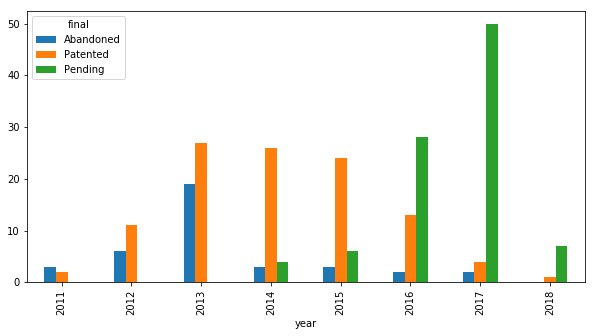

In [10]:
result.plot.bar(figsize=(10,5))

### Average Time to First Action

Maybe we'd like to know how long the Examiner takes from docketing until a first Office Action. To do that, we'll use the transaction information stored on each case. For example, from our original app, the transactions look like this:

In [11]:
pd.DataFrame.from_records(app.transactions).head()

,code,description,record_date
0,M1551,"Payment of Maintenance Fee, 4th Year, Large En...",2018-07-06
1,PGM/,Recordation of Patent Grant Mailed,2015-01-13
2,EML_NTR,Email Notification,2014-12-25
3,WPIR,Issue Notification Mailed,2014-12-23
4,PTAC,Patent Issue Date Used in PTA Calculation,2015-01-13


First, we need to know all the possible transaction codes. To do that, we can take every case in the examiner's stack, and create a set of code-description tuples

In [12]:
exam_codes = list(set((r['code'], r['description']) for a in examiners_applications for r in a.transactions))
exam_codes = [{'code': r[0], 'description': r[1]} for r in exam_codes]
codes_df = pd.DataFrame.from_records(exam_codes)
codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 2 columns):
code           239 non-null object
description    239 non-null object
dtypes: object(2)
memory usage: 3.8+ KB


Obviously there are entirely too many possible codes / descriptions to easily pick through in a notebook, so we'll export the spreadsheet to excel for review

In [13]:
codes_df.to_excel('codes.xlsx')

After review, it looks like all the relevant codes for a first action by the examiner begin one one of three prefixes - MFA, CT, or MC. And the case is initially docketed with a code 'DOCK'. So let's use this to calculate a time to first office action for each case. Since we're digging deeper into each case, we'll put the applications themselves as a column of the dataframe.

In [14]:
app_df = pd.DataFrame.from_records({'appl_id': a.appl_id, 'obj': a} for a in examiners_applications if 'PCT' not in a.appl_id)
app_df.head()

,appl_id,obj
0,13046650,<USApplication(appl_id=13046650)>
1,13256177,<USApplication(appl_id=13256177)>
2,13273818,<USApplication(appl_id=13273818)>
3,13280377,<USApplication(appl_id=13280377)>
4,13323676,<USApplication(appl_id=13323676)>


Now we'll write a function that takes an application, and returns the time to first Examiner's action, measured as days from DOCK to an action by the examiner

In [16]:
import re
from datetime import datetime

first_action_re=re.compile('^(MFA|CT|MC)')

def time_to_action(row):
    #print(obj.transactions)
    obj = row['obj']
    transactions = sorted(obj.transaction_history, key=lambda x: x.date)
    docketing_date = next(r for r in transactions if r.code == 'DOCK').date
    try:
        first_action = next(r for r in transactions if first_action_re.search(r.code))
    except StopIteration:
        return row
    row['first_action'] = first_action.description
    row['first_action_date'] = first_action.date
    row['docketed_date'] = docketing_date
    
    row['time_to_action'] = (
        first_action.date
        - docketing_date
    ).days
    return row


app_df= app_df.apply(time_to_action, axis=1)
app_df = app_df.astype({'docketed_date': datetime, 'first_action_date': datetime})
app_df.head()

,appl_id,docketed_date,first_action,first_action_date,obj,time_to_action
0,13046650,2011-07-05,Non-Final Rejection,2013-03-02,<USApplication(appl_id=13046650)>,606.0
1,13256177,2011-10-31,Non-Final Rejection,2013-09-16,<USApplication(appl_id=13256177)>,686.0
2,13273818,2012-02-03,Non-Final Rejection,2014-04-07,<USApplication(appl_id=13273818)>,794.0
3,13280377,2011-12-06,Non-Final Rejection,2013-11-13,<USApplication(appl_id=13280377)>,708.0
4,13323676,2012-02-03,Non-Final Rejection,2013-11-18,<USApplication(appl_id=13323676)>,654.0


And now we can look at the aggregate stats for time to first office action:

In [17]:
app_df.describe()

,time_to_action
count,191.000000
mean,355.476440
std,199.396532
min,0.000000
25%,201.500000
50%,373.000000
75%,520.500000
max,794.000000


We can also look at the average time by what the response type is:

In [18]:
app_df.groupby('first_action').describe()

time_to_action              \
                                                   count        mean   
first_action                                                           
Mail First Action Interview Office Action            1.0  672.000000   
Non-Final Rejection                                179.0  352.737430   
Restriction/Election Requirement                    11.0  371.272727   

                                                                            \
                                                  std    min    25%    50%   
first_action                                                                 
Mail First Action Interview Office Action         NaN  672.0  672.0  672.0   
Non-Final Rejection                        199.089566    0.0  201.5  370.0   
Restriction/Election Requirement           198.646969   24.0  219.5  422.0   

                                                         
                                             75%    max  
first_action                                             
Mail First Action Interview Office Action  672.0  672.0  
Non-Final Rejection                        515.5  794.0  
Restriction/Election Requirement           514.0  584.0